In [100]:
get_ipython().magic('matplotlib inline')
import os
from pandas import *
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 
import sys 
import numpy as np
import csv 
import seaborn as sns
import scipy.io

import scipy.signal as signal
from scipy.stats import norm

from scipy import signal
from scipy.stats import stats
from scipy.stats import ttest_ind
from scipy.stats import wilcoxon
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix

from sqlalchemy import Index 
from matplotlib.ticker import MaxNLocator

import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor

In [2]:
folder = r"../data/"

In [3]:
# Graph parameters

# color lines 
brown = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
blue =  (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
pal = [green, brown, blue]
sns.set_palette(pal)

# labels
plt.rcParams["font.size"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

# Labels

In [4]:
# mapping values preparation
FC=np.genfromtxt(folder + 'fc_s0001'+'.txt')

188 188


# DATA

* Group1: 10 participants each participant has a matrix 188*188 which is symetric so we only keep the lower part of the marix 
* Group2: 10 participants each participant has a matrix 188*188 which is symetric so we only keep the lower part of the marix



In [6]:
# 2 groups join in one matrix
Nsub=10
lowerFC = np.tril_indices(188, k=-1)
FC_emp_all=[]
for nsub in range(Nsub): #Control
    s=nsub+1
    fc=np.genfromtxt(folder +'fc_s00'+("%02d" % s)+'HT.txt') # Group 1: 10*(188,188)
    FC_emp_all.append(fc[lowerFC])
for nsub in range(Nsub): #Mutant
    s=nsub+1
    fc=np.genfromtxt(folder +'fc_s00'+("%02d" % s)+'WT.txt') # Group 2: 10*(188,188)
    FC_emp_all.append(fc[lowerFC])
#np.save('FC_emp_all.npy',FC_all) # Matrix (20,188,188)

In [7]:
np.array(FC_emp_all).shape

(20, 17578)

## Dataset -X START TO ADAPT FROM HERE
Create a Data set call X (2D matrix) of the shape (Subjects,Features)

To put all the subjects together in one matrix: 
* G1 (called H1) first from 0 to 10
* G2 (called M1) second from 10 to 20

To take as the features either: 
* Lower part of the matrix 188*188 (FC) minus diagonal (because symmetric)
* Entire matrix 188*188 (EC) because not symmetric
* Only some specific regions of the matrix 188*188 (regions IDnames) + take only the lower part of it (because symmetric)

In [8]:
X = np.array(FC_emp_all)

In [ ]:
FC_emp_all_HT_16p11=np.load(folder +'FC_emp_all_HT_16p11.2.npy')
FC_emp_all_WT_16p11=np.load(folder +'FC_emp_all_WT_16p11.2.npy')

H1=FC_emp_all_WT_16p11
M1=FC_emp_all_HT_16p11

Text(0.5,1,'Dataset')

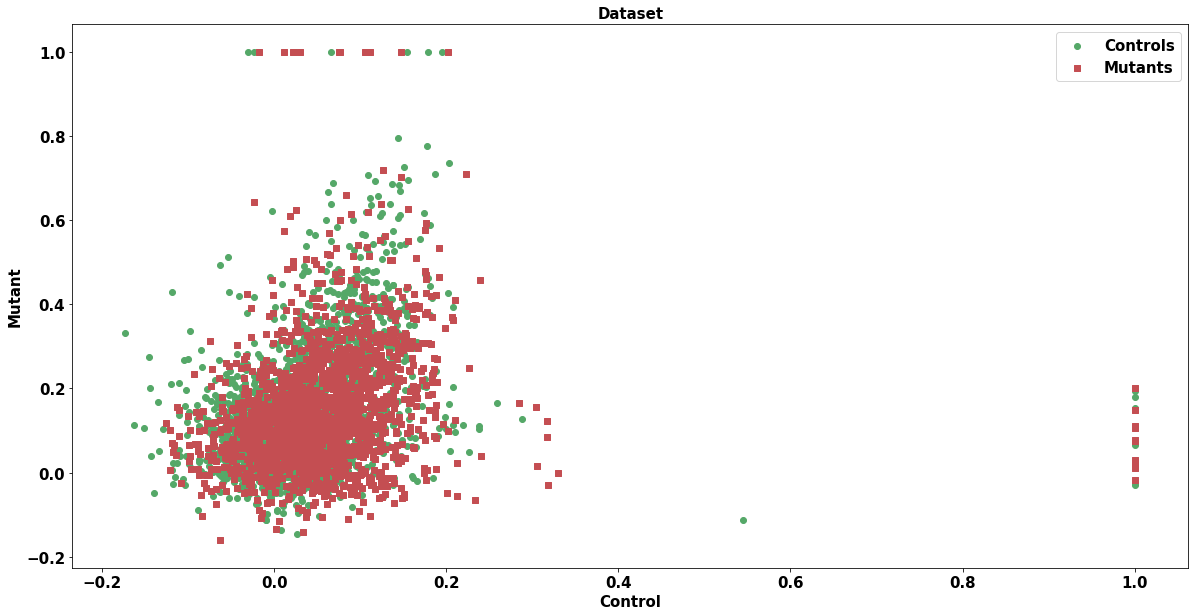

In [23]:
# Plot dataset
plt.figure(figsize=(20,10))
plt.scatter(H1[:, 0], H1[:, 1], marker='o') #Control
plt.scatter(M1[:, 0], M1[:, 1], marker='s') #Mutant
plt.xlabel('Control')
plt.ylabel('Mutant')
plt.legend(['Controls','Mutants'])
plt.title('Dataset')

Text(0,0.5,'Probability')

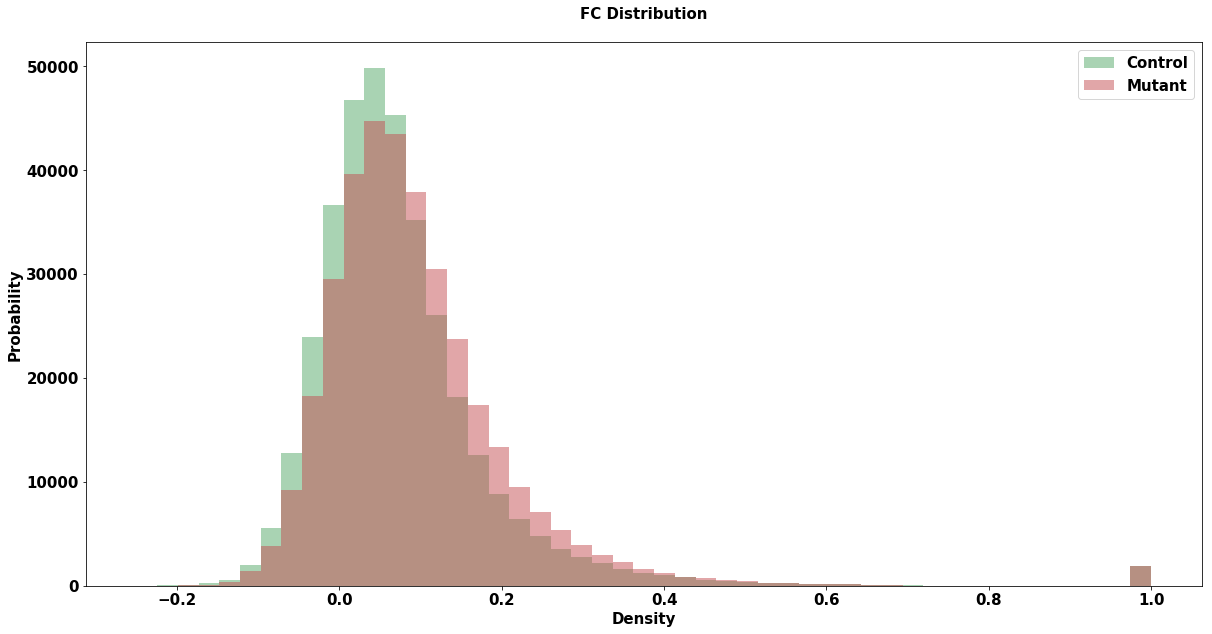

In [24]:
# Probability Distribution 
plt.figure(figsize=(20,10))
plt.hist(H1.reshape(-1),bins=np.linspace(-0.25,1,50), alpha=0.5)
plt.hist(M1.reshape(-1),bins=np.linspace(-0.25,1,50), alpha=0.5)
plt.title('FC Distribution\n')
plt.legend(['Control','Mutant'])
plt.xlabel('Density')
plt.ylabel('Probability')

with lines (2 in our case)
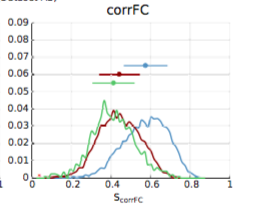

## Supervised Learning -Y

* 1st half of the participants in the X matrix are in G1 so label 0
* 2nd half of the participants in the X matrix are in G2 so label 1

In [25]:
y = np.array([0 if group_id<np.shape(X)[0]//2 else 1 for group_id in range(np.shape(X)[0])]) 

## Classification

Can we classify the 2 groups? Can the classificator identified well that one participant is part of the good group? 
* Classificator type: MLR, 1-NN, RandomForestClassifier
* Pipeline: z-score, PCA, clf
* Cross-validation: Train, Test
* Recursive Feature Elimination: RFECV

Link= http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [67]:
# Classifier 1: Multinomial logistic regression
clf = LogisticRegression(C=10000, penalty='l2', multi_class= 'multinomial', solver='lbfgs')

In [68]:
# corresponding pipeline:
pipe_pca_mlr = Pipeline([('pca', PCA()),
                         ('clf', clf)])

#pipe_pca_mlr = Pipeline([('pca', PCA(n_components=2)),
#                         ('clf', clf)])

In [69]:
# Cross-validation: training + test
repetitions = 50  # number of times the train/test split is repeated

# shuffle splits for validation test accuracy
shS = ShuffleSplit(n_splits=repetitions, test_size=None, train_size=.8, random_state=0)

score_pca_mlr = np.zeros([repetitions])

i = 0  # counter for repetitions
for train_idx, test_idx in shS.split(X):  # repetitions loop
    data_train = X[train_idx, :]
    y_train = y[train_idx]
    data_test = X[test_idx, :]
    y_test = y[test_idx]

    pipe_pca_mlr.fit(data_train, y_train)
    score_pca_mlr[i] = pipe_pca_mlr.score(data_test, y_test)
    i+=1

In [70]:
# print accuracy 
print("classifier accuracy: %1.2f" %(pipe_pca_mlr.score(X, y)))
print("Accuracy: %1.2f +/- %.2f (mean +/- standard deviation)" %(score_pca_mlr.mean(), score_pca_mlr.std()))

classifier accuracy: 0.85
Accuracy: 0.62 +/- 0.20 (mean +/- standard deviation)


In [58]:
# To verify with other pipelines: 
pipe_mlr = Pipeline([('clf', clf)])

# Cross-validation: training + test
repetitions = 50  # number of times the train/test split is repeated

# shuffle splits for validation test accuracy
shS = ShuffleSplit(n_splits=repetitions, test_size=None, train_size=.8, random_state=0)
score_mlr = np.zeros([repetitions])

i = 0  # counter for repetitions
for train_idx, test_idx in shS.split(X):  # repetitions loop
    data_train = X[train_idx, :]
    y_train = y[train_idx]
    data_test = X[test_idx, :]
    y_test = y[test_idx]
    pipe_mlr.fit(data_train, y_train)
    score_mlr[i] = pipe_mlr.score(data_test, y_test)
    i+=1

In [59]:
# print accuracy 
print("classifier accuracy: %1.2f" %(pipe_mlr.score(X, y)))
print("Accuracy: %1.2f +/- %.2f (mean +/- standard deviation)" %(score_mlr.mean(), score_mlr.std()))

classifier accuracy: 0.85
Accuracy: 0.61 +/- 0.22 (mean +/- standard deviation)


In [60]:
# To verify with other pipelines: 
pipe_z_pca_mlr = Pipeline([('zscore', StandardScaler()), 
                         ('pca', PCA()),
                         ('clf', clf)])

# Cross-validation: training + test
repetitions = 50  # number of times the train/test split is repeated

# shuffle splits for validation test accuracy
shS = ShuffleSplit(n_splits=repetitions, test_size=None, train_size=.8, random_state=0)

score_z_pca_mlr = np.zeros([repetitions])

i = 0  # counter for repetitions
for train_idx, test_idx in shS.split(X):  # repetitions loop
    data_train = X[train_idx, :]
    y_train = y[train_idx]
    data_test = X[test_idx, :]
    y_test = y[test_idx]
    with np.errstate(invalid='ignore'):
        pipe_z_pca_mlr.fit(data_train, y_train)
    score_z_pca_mlr[i] = pipe_z_pca_mlr.score(data_test, y_test)
    i+=1

In [61]:
# print accuracy 
print("classifier accuracy: %1.2f" %(pipe_z_pca_mlr.score(X, y)))
print("Accuracy: %1.2f +/- %.2f (mean +/- standard deviation)" %(score_z_pca_mlr.mean(), score_z_pca_mlr.std()))

classifier accuracy: 0.85
Accuracy: 0.60 +/- 0.19 (mean +/- standard deviation)


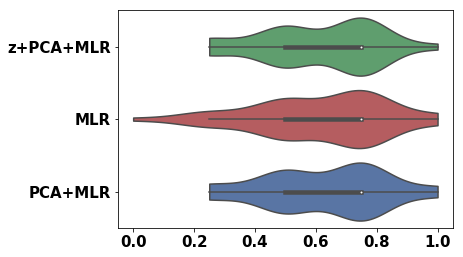

In [62]:
# plot comparison as violin plots
fig, ax = plt.subplots()
sns.violinplot(data=[score_z_pca_mlr, score_mlr, score_pca_mlr], cut=0, orient='h', scale='width')
ax.set_yticklabels(['z+PCA+MLR', 'MLR', "PCA+MLR"])
plt.show()

In [52]:
# Classifier 2: 1-nearest-neighbour
pipe_pca_mlr = Pipeline([('pca', PCA()),
                         ('clf', clf)])

# classifier: logistic regression
clf = KNeighborsClassifier(n_neighbors=1)

# cross-validation
repetitions = 50

# shuffle splits for validation test accuracy
shS = ShuffleSplit(n_splits=repetitions, test_size=None, train_size=.8, random_state=0)
#score = np.zeros([repetitions])
score_pca_mlr = np.zeros([repetitions])

i = 0  # counter for repetitions
for train_idx, test_idx in shS.split(X):  # repetitions loop
    data_train = X[train_idx, :]
    y_train = y[train_idx]
    data_test = X[test_idx, :]
    y_test = y[test_idx]

    clf.fit(data_train, y_train)
    pipe_pca_mlr.fit(data_train, y_train)
    #score[i] = clf.score(data_test, y_test)
    score_pca_mlr[i] = pipe_pca_mlr.score(data_test, y_test)

    i+=1

# print accuracy 
print("classifier accuracy: %1.2f" %(pipe_pca_mlr.score(X, y)))
print("Accuracy: %1.2f +/- %.2f (mean +/- standard deviation)" %(score_pca_mlr.mean(), score_pca_mlr.std()))     

classifier accuracy: 0.95
Accuracy: 0.57 +/- 0.23 (mean +/- standard deviation)


[Text(0,0,'1-NN')]

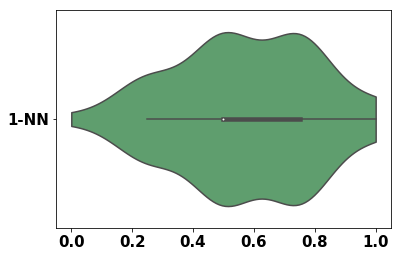

In [37]:
# plot comparison as violin plots
fig, ax = plt.subplots()
sns.violinplot(data=[score_pca_mlr], cut=0, orient='h', scale='width')
#sns.violinplot(data=[score], cut=0, orient='h', scale='width')
ax.set_yticklabels(['1-NN'])

## Comparison with the chance level
* For 1-NN
* For MLR

In [83]:
# Classifier 2: 1-nearest-neighbour

# chance level
y_rnd = np.random.permutation(y)

# classifier: logistic regression
clf = KNeighborsClassifier(n_neighbors=1)

# pipeline
pipe_pca_mlr = Pipeline([('pca', PCA()),
                         ('clf', clf)])
pipe_pca_mlr_rnd = Pipeline([('pca', PCA()),
                         ('clf', clf)])

# cross-validation
repetitions = 50

# shuffle splits for validation test accuracy
shS = ShuffleSplit(n_splits=repetitions, test_size=None, train_size=.8, random_state=0)

#score = np.zeros([repetitions])
score_pca_mlr = np.zeros([repetitions])
score_rnd = np.zeros([repetitions]) # chance level

i = 0  # counter for repetitions
for train_idx, test_idx in shS.split(X):  # repetitions loop
    data_train = X[train_idx, :]
    y_train = y[train_idx]
    data_test = X[test_idx, :]
    y_test = y[test_idx]

    clf.fit(data_train, y_train)
    pipe_pca_mlr.fit(data_train, y_train)
    pipe_pca_mlr_rnd.fit(data_train, y_train)
    
    #score[i] = clf.score(data_test, y_test)
    score_pca_mlr[i] = pipe_pca_mlr.score(data_test, y_test)
    score_rnd[i] = pipe_pca_mlr_rnd.score(data_test, y_test)

    i+=1

# print accuracy 
#print("classifier accuracy: %1.2f" %(pipe_pca_mlr.score(X, y)))
print("Accuracy: %1.2f +/- %.2f (mean +/- standard deviation)" %(score_pca_mlr.mean(), score_pca_mlr.std()))     
print("Chance level: %1.2f +/- %.2f (mean +/- standard deviation)" %(score_rnd.mean(), score_rnd.std()))     

Accuracy: 0.57 +/- 0.23 (mean +/- standard deviation)
Chance level: 0.57 +/- 0.23 (mean +/- standard deviation)


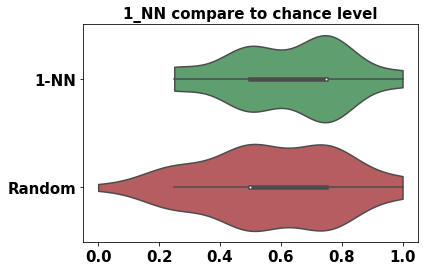

In [72]:
# plot comparison as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score_pca_mlr, score_rnd], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['1-NN', 'Random'])
ax.set_title('1_NN compare to chance level')
plt.show()

In [73]:
# Classifier 2: MLR

# chance level
y_rnd = np.random.permutation(y)

# classifier: logistic regression
clf = LogisticRegression(C=10000, penalty='l2', multi_class= 'multinomial', solver='lbfgs')

# pipeline
pipe_pca_mlr = Pipeline([('pca', PCA()),
                         ('clf', clf)])
pipe_pca_mlr_rnd = Pipeline([('pca', PCA()),
                         ('clf', clf)])

# cross-validation
repetitions = 50

# shuffle splits for validation test accuracy
shS = ShuffleSplit(n_splits=repetitions, test_size=None, train_size=.8, random_state=0)

#score = np.zeros([repetitions])
score_pca_mlr = np.zeros([repetitions])
score_rnd = np.zeros([repetitions]) # chance level

i = 0  # counter for repetitions
for train_idx, test_idx in shS.split(X):  # repetitions loop
    data_train = X[train_idx, :]
    y_train = y[train_idx]
    data_test = X[test_idx, :]
    y_test = y[test_idx]

    clf.fit(data_train, y_train)
    pipe_pca_mlr.fit(data_train, y_train)
    pipe_pca_mlr_rnd.fit(data_train, y_train)
    
    #score[i] = clf.score(data_test, y_test)
    score_pca_mlr[i] = pipe_pca_mlr.score(data_test, y_test)
    score_rnd[i] = pipe_pca_mlr_rnd.score(data_test, y_test)

    i+=1

# print accuracy 
#print("classifier accuracy: %1.2f" %(pipe_pca_mlr.score(X, y)))
print("Accuracy: %1.2f +/- %.2f (mean +/- standard deviation)" %(score_pca_mlr.mean(), score_pca_mlr.std()))     
print("Chance level: %1.2f +/- %.2f (mean +/- standard deviation)" %(score_rnd.mean(), score_rnd.std()))     

Accuracy: 0.62 +/- 0.20 (mean +/- standard deviation)
Chance level: 0.62 +/- 0.20 (mean +/- standard deviation)


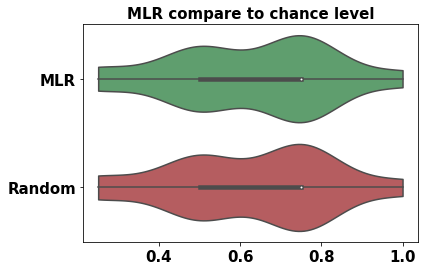

In [75]:
# plot comparison as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score_pca_mlr, score_rnd], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['MLR', 'Random'])
ax.set_title('MLR compare to chance level')
plt.show()

## Plot 

* PCA over PCA space (2D or 3D plot)
* Classifier Plot
* Accuracy over Features for each classificator type and it's comparison with the chance level


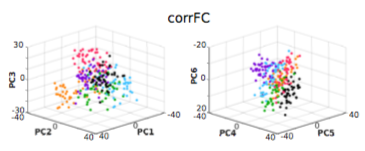

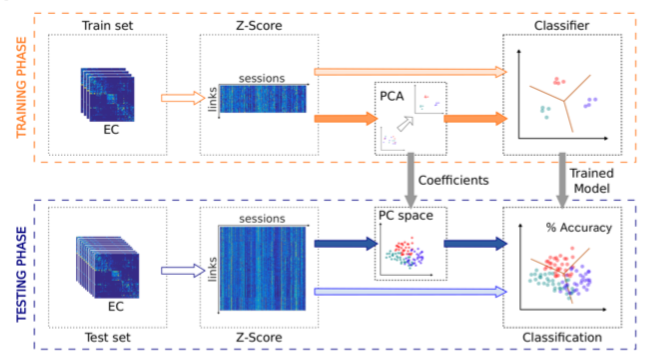

Instead of subjects and sessions it is features or subjects
We have only one line corrFC
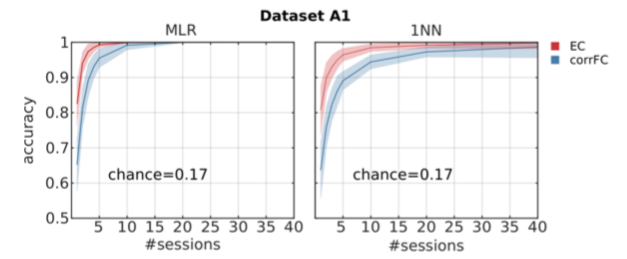

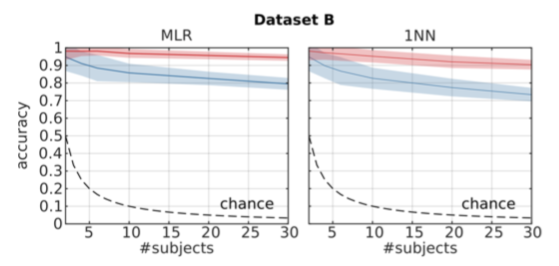



## Recursive Feature Elimination: RFECV

Which Features are more informative to classify? 

* save the rank of the Features Elimination one with the number of the Features and another one with the ID_Name
* Plot accuracy over features 
* Plot matrix average RFE ranking

Are they the same features for each participant? 
How much informative are they? 

References: https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2
https://machinelearningmastery.com/an-introduction-to-feature-selection/

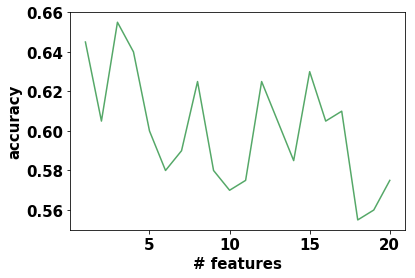

In [103]:
# classifier with MLR and PCA
#clf = LogisticRegression(C=1000, penalty='l2', multi_class= 'multinomial', solver='lbfgs')
clf = RandomForestClassifier()
#clf = RandomForestRegressor()
#clf = SelectFromModel(LinearSVC(C=0.01, penalty='l1', dual=False))

repetitions = 50
# CV object
shS = StratifiedShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=0)
pca_std = PCA().fit(X)
X_std = pca_std.transform(X)
# RFE object
rfecv = RFECV(estimator=clf, step=1, cv=shS,
              scoring='accuracy')

# fit RFE by CV
rfecv.fit(X_std, y)

# figure
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('# features')
plt.ylabel('accuracy')
plt.show()

In [78]:
# classifier with SVC and PCA

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# CV object
repetitions = 50
shS = StratifiedShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=0)
#pca_std = PCA().fit(X)
#X_std = pca_std.transform(X)

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=shS,
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

KeyboardInterrupt: 

In [19]:
# classifier without PCA
clf = LogisticRegression(C=1000, penalty='l2', multi_class= 'multinomial', solver='lbfgs')
repetitions = 50
# CV object
shS = StratifiedShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=0)

# RFE object
rfecv = RFECV(estimator=clf, step=1, cv=shS,
              scoring='accuracy')
# fit RFE by CV
rfecv.fit(X, y)

# figure
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('# features')
plt.ylabel('accuracy')
plt.show()

KeyboardInterrupt: 

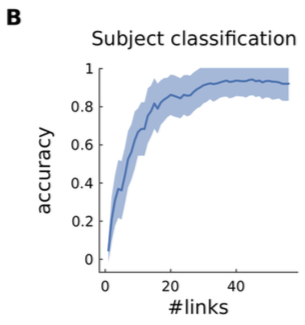

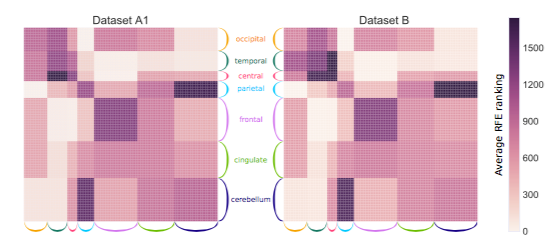

## Why, How and When to apply Feature Selection
#### 1. Filter Methods
Filter Methods considers the relationship between features and the target variable to compute the importance of features.
##### a. F Test
##### b. Mutual Information
##### c. Variance Threshold

#### 2. Wrapper Methods
Wrapper Methods generate models with a subsets of feature and gauge their model performances.
##### a. Forward Search
##### b. Recursive Feature Elimination

#### 3. Embedded Methods
Feature selection can also be acheived by the insights provided by some Machine Learning models.
##### a. LASSO Linear Regression
##### b. Tree based models
The feature importance in tree based models are calculated based on Gini Index, Entropy or Chi-Square value.